/tmp/ipython-input-14-3644563029.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  4 of 4 completed


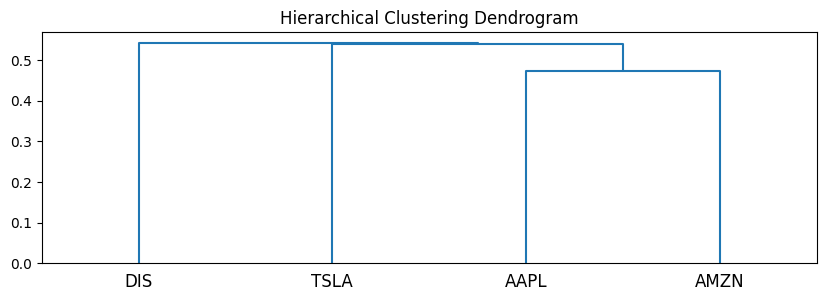

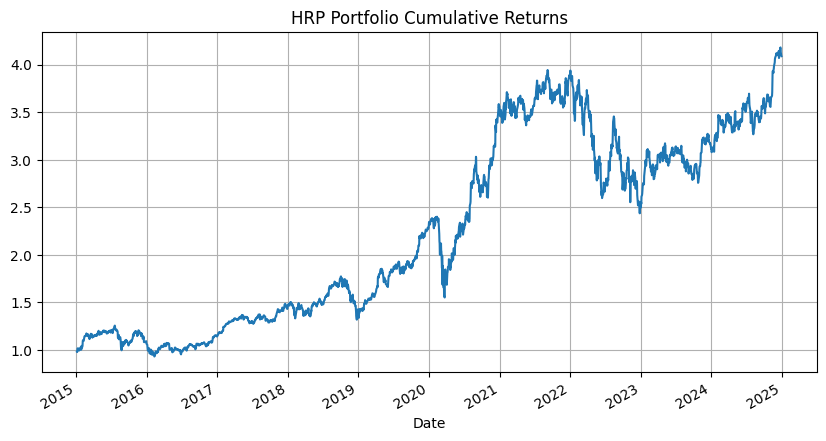

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download adjusted close prices
tickers = ['AAPL', 'AMZN', 'TSLA', 'DIS']
data = yf.download(tickers, start="2015-01-01", end="2025-01-01")['Close']
returns = data.pct_change().dropna()

cov = returns.cov()
corr = returns.corr()

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

def correl_to_dist(corr):
    return np.sqrt(0.5 * (1 - corr))

dist = correl_to_dist(corr)

link = linkage(squareform(dist), method='single')
plt.figure(figsize=(10, 3))
dendrogram(link, labels=corr.columns.tolist())
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

def get_quasi_diag(link):
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]

    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df1 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df1])
        sort_ix = sort_ix.sort_index()

    return sort_ix.tolist()

sorted_idx = get_quasi_diag(link)
ordered_tickers = corr.columns[sorted_idx].tolist()

def get_hrp_weights(cov, sort_order):
    weights = pd.Series(1.0, index=sort_order)
    cluster_items = [sort_order]

    while len(cluster_items) > 0:
        cluster_items = [i[j:k] for i in cluster_items for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]

        for cluster in cluster_items:
            left_cluster = cluster[:len(cluster) // 2]
            right_cluster = cluster[len(cluster) // 2:]

            cov_ = cov.loc[cluster, cluster]
            inv_diag = 1. / np.diag(cov_)
            weights_ = inv_diag / np.sum(inv_diag)

            alpha = weights_.sum() if left_cluster else 0
            for sub_cluster in [left_cluster, right_cluster]:
                if len(sub_cluster) == 0:
                    continue
                w = alpha if sub_cluster == left_cluster else 1 - alpha
                weights[sub_cluster] *= w

    return weights

hrp_weights = get_hrp_weights(cov, ordered_tickers)
hrp_weights = hrp_weights / hrp_weights.sum()
hrp_weights

hrp_returns = (returns * hrp_weights).sum(axis=1)
(1 + hrp_returns).cumprod().plot(figsize=(10, 5), title="HRP Portfolio Cumulative Returns")
plt.grid(True)
plt.show()


/tmp/ipython-input-30-3631996377.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2015-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  4 of 4 completed


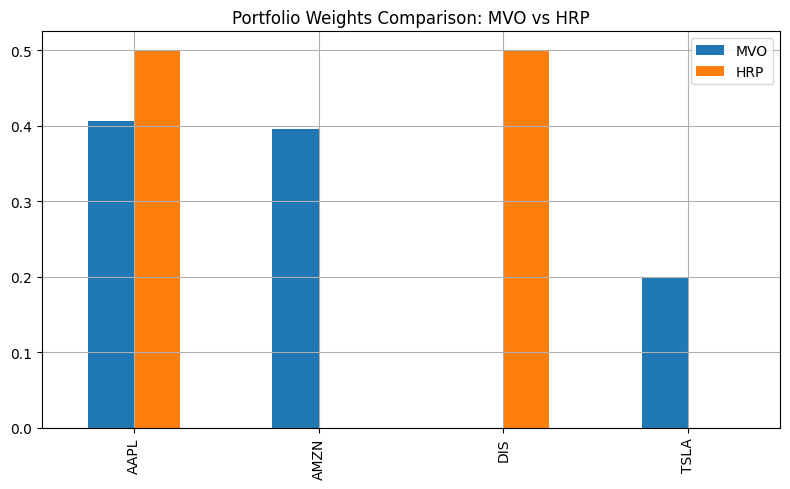

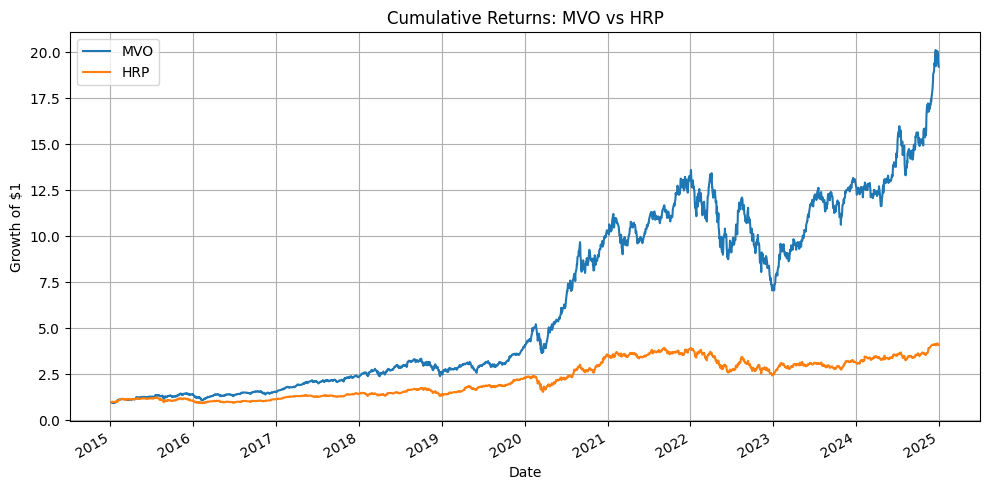

In [30]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import riskfolio as rp

# Define tickers and load price data
tickers = ['AAPL', 'AMZN', 'DIS', 'TSLA']
data = yf.download(tickers, start='2015-01-01', end='2024-12-31')['Close']
returns = data.pct_change().dropna()

port_mvo = rp.Portfolio(returns=returns)
port_mvo.assets_stats(method_mu='hist', method_cov='hist')
w_mvo = port_mvo.optimization(model='Classic', rm='MV', obj='Sharpe', hist=True)

weights = pd.concat([w_mvo, hrp_weights], axis=1)
weights.columns = ['MVO', 'HRP']
weights.plot(kind='bar', figsize=(8, 5), title='Portfolio Weights Comparison: MVO vs HRP')
plt.grid(True)
plt.tight_layout()
plt.show()

cumulative_returns = pd.DataFrame()
cumulative_returns['MVO'] = (returns @ w_mvo).add(1).cumprod()
cumulative_returns['HRP'] = (returns @ hrp_weights).add(1).cumprod()

cumulative_returns.plot(figsize=(10, 5), title="Cumulative Returns: MVO vs HRP")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.tight_layout()
plt.show()



In [45]:
import pandas as pd
import numpy as np

def performance_metrics(daily_returns, name):
    cumulative_return = (1 + daily_returns).prod() - 1
    annual_return = (1 + cumulative_return) ** (252 / len(daily_returns)) - 1
    annual_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    max_drawdown = ((daily_returns.cumsum() + 1).cummax() - (daily_returns.cumsum() + 1)).max()

    return pd.Series({
        'Cumulative Return': cumulative_return,
        'Annual Return (CAGR)': annual_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }, name=name)

# Assuming `mvo_returns` and `hrp_returns` are already defined as daily return series
mvo_metrics = performance_metrics(returns @ w_mvo, "MVO")
hrp_metrics = performance_metrics(hrp_returns, "HRP")

# Combine into a DataFrame
comparison = pd.concat([mvo_metrics, hrp_metrics], axis=1)
print(comparison)


                            MVO       HRP
Cumulative Return     25.652525  3.088464
Annual Return (CAGR)   0.389496  0.151536
Annual Volatility      0.319455  0.236654
Sharpe Ratio           1.219252  0.640328
Max Drawdown           0.655241  0.426075
